## Import modules

In [2]:
from __future__ import absolute_import
# Imports
import scipy.io as sio
from sklearn import linear_model
import numpy as np

# import required libraries
import matplotlib.pyplot as plt
import sys
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Dense, TimeDistributed, Dropout, RepeatVector, LSTM, concatenate, Embedding, Input, BatchNormalization
from keras.layers.core import Activation
from keras import metrics, regularizers
import pickle
import scipy
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifierCV,LogisticRegressionCV, LogisticRegression
from sklearn.metrics import confusion_matrix

import itertools

sys.path.append("../") # go to parent dir
from mrcode.utils.file_utils import fileFinder, folderFinder
from mrcode import settings

## Load data

In [3]:
def std_windows(eeg, time_window = 50):
    temp_eeg = []
    for ii in range(eeg.shape[0]):
        temp_epoch = eeg[ii,:,:]
        temp_eeg.append(np.std(temp_epoch.reshape(int(temp_epoch.shape[0]/time_window),time_window,temp_epoch.shape[1]),1).flatten())
    std_eeg = np.array(temp_eeg)
    return std_eeg

def std_overlap_windows(eeg, time_window = 80, overlap = 0.5):
    temp_eeg = []
    for ii in range(eeg.shape[0]):
        temp_epoch = eeg[ii,:,:]
        std_channels = []
        for jj in range(temp_epoch.shape[1]):
            channel = temp_epoch[:,jj]

            std_channel = []
            for kk in range(int(time_window*overlap)):
                std_channel.append(channel[kk:(kk+time_window)])

            std_channels.append(np.std(std_channel,1))

        temp_eeg.append(std_channels)
        
    temp_eeg_array = np.array(temp_eeg)
    std_temp_eeg = temp_eeg_array.reshape(temp_eeg_array.shape[0],temp_eeg_array.shape[2]*temp_eeg_array.shape[1])
    return std_temp_eeg

def load_data(ii,data_path,feature = 'raw'):
    data = sio.loadmat(data_path + '/' + ii + '/eeg_events.mat')
    eeg = data['eeg_events'].transpose()
    
    if feature == 'raw':
        eeg = eeg.reshape(eeg.shape[0],eeg.shape[2]*eeg.shape[1])
    
    if feature == 'std':
        eeg = std_windows(eeg)
        
    if feature == 'std_overlap':
        eeg = std_overlap_windows(eeg)
                  
    image_info = pd.read_csv(data_path + '/' + ii + '/image_order.txt', delimiter='\t')
    return eeg, image_info


data_path = '../data/experiment_data'
experiment_folders = folderFinder(data_path)
X_train_temp = []
y_train_temp = []
target = 'category'
loadmode = 'raw'
classmode = '' # If animal remember to set target above as supercategory
for count_sources, ii in enumerate(experiment_folders):
    
    if count_sources == 0:
        eeg, image_info = load_data(ii,data_path, feature = loadmode)
        X_train_temp = eeg
        y_train_temp = list(image_info[target].as_matrix())
    
    elif count_sources > 0:
        eeg, image_info = load_data(ii,data_path, feature = loadmode)
        X_train_temp = np.vstack((X_train_temp,eeg))
        y_train_temp = np.hstack((y_train_temp,list(image_info[target].as_matrix())))
    
b = range(20,690*len(experiment_folders),30)
y = pd.get_dummies(y_train_temp)
if classmode == 'animal':
    #Getting only classes animal and nonanimal
    y['nonanimal'] = y.iloc[:,1:6].sum(axis=1)
    y = y.drop(columns=['food','furniture','indoor','outdoor','vehicle'])
y_classes = list(y.columns.values)
y_train = np.array(y)
y_test = y_train[b,:]
y_train = np.delete(y_train,b,0)

Calculate the percentage of each classes

In [4]:
y.sum()/sum(y.sum())

airplane      0.043478
bear          0.043478
bed           0.043478
bench         0.043478
bird          0.043478
boat          0.043478
bus           0.043478
cat           0.043478
clock         0.043478
cow           0.043478
dog           0.043478
donut         0.043478
elephant      0.043478
giraffe       0.043478
horse         0.043478
motorcycle    0.043478
pizza         0.043478
sheep         0.043478
stop sign     0.043478
teddy bear    0.043478
toilet        0.043478
train         0.043478
zebra         0.043478
dtype: float64

## Scale the data

In [5]:
# Normalize data
xScale = StandardScaler().fit(X_train_temp)
X_train_temp = xScale.transform(X_train_temp)

# Split data 
X_test = X_train_temp[b,:]
X_train = np.delete(X_train_temp,b,0)

# Printing shape of data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10005, 17600)
(10005, 23)
(345, 17600)
(345, 23)


## Neural network

In [9]:
model = Sequential()
model.add(Dense(200, activation='relu', name='first_dense', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu', name='second_dense', kernel_initializer='he_normal'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(y_train.shape[1], activation='relu', name='third_dense', kernel_initializer='he_normal'))

model.add(Activation('softmax', name='Softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_dense (Dense)          (None, 200)               3520200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
second_dense (Dense)         (None, 100)               20100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
third_dense (Dense)          (None, 23)                2323      
__________

## Use Keras to perform linear classification

In [5]:
model = Sequential()
model.add(Dense(23, activation='linear', kernel_regularizer=regularizers.l2(0.5), name='first_dense', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)))
model.add(Activation('softmax', name='Softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_dense (Dense)          (None, 23)                404823    
_________________________________________________________________
Softmax (Activation)         (None, 23)                0         
Total params: 404,823
Trainable params: 404,823
Non-trainable params: 0
_________________________________________________________________


In [7]:
batch_size = 32
epochs = 50
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(X_test, y_test))

Train on 10005 samples, validate on 345 samples
Epoch 1/50
10005/10005 [==============================] - 9s 926us/step - loss: 6.9153 - acc: 0.0564 - val_loss: 3.9225 - val_acc: 0.0725
Epoch 2/50
10005/10005 [==============================] - 5s 503us/step - loss: 4.0428 - acc: 0.0698 - val_loss: 4.1708 - val_acc: 0.0754
Epoch 3/50
10005/10005 [==============================] - 5s 513us/step - loss: 4.0309 - acc: 0.0691 - val_loss: 3.9205 - val_acc: 0.0783
Epoch 4/50
10005/10005 [==============================] - 5s 522us/step - loss: 4.0830 - acc: 0.0632 - val_loss: 3.8056 - val_acc: 0.0783
Epoch 5/50
10005/10005 [==============================] - 5s 515us/step - loss: 4.0373 - acc: 0.0692 - val_loss: 4.2058 - val_acc: 0.0522
Epoch 6/50
10005/10005 [==============================] - 5s 508us/step - loss: 4.0237 - acc: 0.0742 - val_loss: 4.0418 - val_acc: 0.0493
Epoch 7/50
10005/10005 [==============================] - 5s 507us/step - loss: 4.1652 - acc: 0.0662 - val_loss: 3.8881 - va

KeyboardInterrupt: 

## Sklearn approach

In [6]:
from mrcode.preprocessing import experiment_data

In [7]:
X_train, y_train, X_test, y_test, X_val, y_val = experiment_data.load_data()

============ Data Loaded ============
X_train shape: (9660, 17600)
X_val shape: (345, 17600)
X_test shape: (345, 17600)
y_train shape: (9660, 23)
y_val shape: (345, 23)
y_test shape: (345, 23)




In [8]:
y_train_new = y_train.argmax(1)
y_test_new = y_test.argmax(1)
y_train_new.shape

(9660,)

In [9]:
ridge_model = LogisticRegressionCV(cv=3)
ridge_model.fit(X_train,y_train_new)

LogisticRegressionCV(Cs=10, class_weight=None, cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [10]:
y_predict = ridge_model.predict(X_test)

In [11]:
trues = 0
false = 0
for i in range(len(y_predict)):
    if y_predict[i] == y_test_new[i]:
        trues += 1
    else:
        false += 1

In [36]:
confusion_matrix(y_test_new, y_predict)

array([[1, 1, 0, 1, 0, 2, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 2, 1, 0, 1,
        1],
       [1, 2, 0, 2, 0, 0, 1, 2, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        1],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 1, 2, 1, 0, 1, 1, 0, 1, 3, 0, 1,
        0],
       [0, 1, 0, 0, 0, 1, 0, 0, 2, 1, 1, 2, 0, 0, 1, 1, 0, 1, 2, 0, 2, 0,
        0],
       [0, 0, 0, 1, 0, 0, 1, 4, 0, 1, 2, 0, 0, 1, 0, 2, 0, 0, 0, 0, 2, 0,
        1],
       [0, 0, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0, 0, 0, 0, 2, 1, 1, 1, 0, 1, 3,
        0],
       [2, 0, 0, 0, 1, 0, 0, 0, 2, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 1,
        1],
       [0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 1, 0, 3, 0, 0, 1, 2, 0, 0, 0, 1, 2,
        0],
       [0, 0, 0, 0, 2, 0, 1, 0, 2, 1, 1, 2, 0, 0, 0, 2, 0, 1, 0, 0, 2, 0,
        1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 4, 3, 0, 2, 1, 1, 0, 0,
        0],
       [0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 2, 1, 3, 0,
        0],
       [0, 1, 0, 0, 0, 2, 1, 1, 2, 0, 0, 2, 1, 0, 0, 1

In [35]:
sum(y_predict-y_test_new==0)/len(y_test_new)

0.08115942028985507

In [14]:
trues

28

In [15]:
false

317

In [3]:
def plot_confusion_matrix(cm, classes, accuracy,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.colorbar()
    plt.title(title + ' - Accuracy: ' + str(accuracy)+'%', fontsize = 24.0)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90.0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize = 20.0)
    plt.xlabel('Predicted label', fontsize = 20.0)

In [4]:
labels = folderFinder(settings.data_path_init() + '/images/')

In [40]:
y_test1 = [labels[ii] for ii in y_test_new]
predictions1 = [labels[ii] for ii in y_predict]

In [59]:
# save
import pickle
with open("y_test1.txt", "wb") as fp:   #Pickling
    pickle.dump(y_test1, fp)
with open("predictions1.txt", "wb") as fp:   #Pickling
    pickle.dump(predictions1, fp)
with open("y_predict.txt", "wb") as fp:   #Pickling
    pickle.dump(y_predict, fp)

In [7]:
# load
with open("y_test1.txt", "rb") as fp:
    y_test1 = pickle.load(fp)
with open("predictions1.txt", "rb") as fp:
    predictions1 = pickle.load(fp)
with open("y_predict.txt", "rb") as fp:
    y_predict = pickle.load(fp)

In [8]:
conf_mat = confusion_matrix(y_test1, predictions1, labels)

In [13]:
#accuracy = 8
accuracy = 16
#accuracy = 19

In [29]:
conf_mat_cca = [[float('NaN'),0,0,2,0,0,1,0,0,0,0,0,1,0,0],
                [0,float('NaN'),0,1,0,0,0,0,0,0,0,0,0,0,1],
                [0,0,float('NaN'),0,0,0,0,0,0,0,0,0,0,0,0],
                [2,1,0,float('NaN'),0,0,0,1,0,0,0,0,0,0,1],
                [0,0,0,0,float('NaN'),0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,float('NaN'),1,0,0,0,0,2,0,0,0],
                [1,0,0,0,0,1,float('NaN'),0,0,0,0,0,0,0,0],
                [0,0,0,1,0,0,0,float('NaN'),0,0,0,1,0,0,5],
                [0,0,0,0,0,0,0,0,float('NaN'),2,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,2,float('NaN'),0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,float('NaN'),0,0,0,0],
                [0,0,0,0,0,2,0,1,0,0,0,float('NaN'),0,0,0],
                [1,0,0,0,0,0,0,0,0,0,0,0,float('NaN'),2,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,2,float('NaN'),0],
                [0,1,0,1,0,0,0,5,0,0,0,0,0,0,float('NaN')]]

In [53]:
conf_mat_basis = [[float('NaN'),0,1,0,0,0,0,0,0,0,1,0,0,0,0],
                [0,float('NaN'),1,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,1,float('NaN'),0,0,0,0,0,0,0,0,0,0,0,1],
                [0,0,0,float('NaN'),0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,float('NaN'),0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,float('NaN'),0,0,0,2,0,0,0,0,0],
                [0,0,0,0,0,0,float('NaN'),0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,float('NaN'),1,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,1,float('NaN'),0,0,0,3,0,0],
                [0,0,0,0,0,2,0,0,0,float('NaN'),0,0,0,0,0],
                [1,0,0,0,0,0,0,0,0,0,float('NaN'),0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,float('NaN'),0,0,0],
                [0,0,0,0,0,0,0,0,3,0,0,0,float('NaN'),0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,float('NaN'),0],
                [0,0,1,0,0,0,0,0,0,0,0,0,0,0,float('NaN')]]

In [54]:
#conf_mat = np.load('conf_mat_best.npy')

In [55]:
def plot_confusion_matrix_cca(cm, classes,
                          normalize=True,
                          cmap=plt.cm.Greens):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.colorbar()
    plt.title('Number of significant components between subjects in CCA', fontsize = 22.0)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90.0)
    plt.yticks(tick_marks, classes)
    cm = np.asarray(cm)
    fmt = '.2f' if normalize else 'd'
    thresh = 2 #cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center", verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Subject', fontsize = 20.0)
    plt.xticks(rotation = 90)
    plt.xlabel('Subject', fontsize = 20.0)

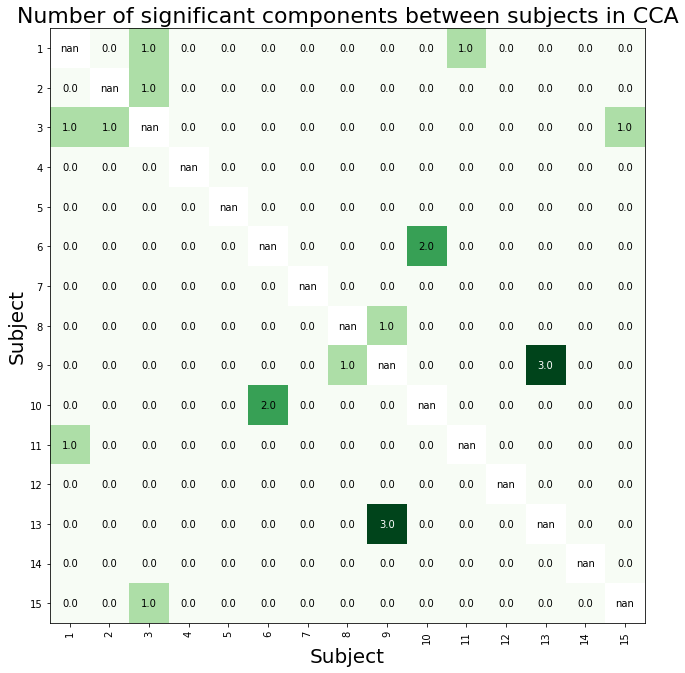

In [56]:
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
labels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
plot_confusion_matrix_cca(conf_mat_basis, labels, accuracy)
#plt.colorbar()
plt.savefig('cca_intersubject_basis.png', bbox_inches = 'tight')
plt.show()

## Prediction keras method

In [19]:
testPredict = model.predict(X_test)
predict_classes = testPredict.argmax(1)
true_classes = y_test.argmax(1)


In [20]:
#print(true_classes)
#print(predict_classes)

hej = np.array(predict_classes-true_classes == 0)
hej = sum(hej.reshape(5, 23),0)
print(hej)
print(sum(hej)/115)
#len(predict_classes)

[1 2 0 1 0 1 1 0 0 0 0 0 1 0 2 0 0 0 1 0 0 0 0]
0.0869565217391


In [ ]:
predictions = metrics.top_k_categorical_accuracy(y_test,testPredict,k=1)

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
v = sess.run(predictions)    
print(v) # will show you your variable.